In [1]:
# Trafic Engineering

In [2]:
import pandas as pd, sqlite3
from pandas import Series, DataFrame

In [3]:
%matplotlib inline

In [4]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 13})

In [5]:
df = pd.read_csv('spend.csv')
df = df.fillna(0)
df['fy2015'] = df['fy2015'] / 1000000
df['fy2016'] = df['fy2016'] / 1000000
df['fy2017'] = df['fy2017'] / 1000000
df['fy2018'] = df['fy2018'] / 1000000
df.tail()

,agency,organization,account_type,character_code,object,fy2015,fy2016,fy2017,fy2018
8638,16 - HUMAN RESOURCES,16300 - HR ORGANIZATIONAL & HEALTH DEV,Expense,53 - SUPPLIES,53140 - HARDWARE SUPPLIES,0.0,0.0,0.0,0.004020
8639,50 - LIBRARY,50221751 - LIB COMM ENGAGE YOUTH CENTRAL,Expense,54 - PURCHASED SERVICES,54520 - CONFERENCES AND TRAINING,0.0,0.0,0.0,0.006506
8640,15 - FINANCE,15200 - FIN BUDGET AND PROGRAM MGMT,Expense,54 - PURCHASED SERVICES,54645 - CONSULTING SERVICES,0.0,0.0,0.0,0.013590
8641,31 - POLICE,31156 - PARKING,Expense,59 - TRANSFER OUT,59213 - TRANSFER OUT TO PARKING UTILIT,0.0,0.0,0.0,0.085000
8642,20 - MUNICIPAL COURT,20100 - MUNICIPAL COURT,Expense,57 - INTER DEPART CHARGES,57162 - ID CHARGE FROM COMMUNITY DEVEL,0.0,0.0,0.0,0.090000


In [6]:
conn = sqlite3.connect('expenditure.db')
df.to_sql('expenditure_table', conn, if_exists='replace', index=False)

In [7]:
pd.read_sql('SELECT * FROM expenditure_table LIMIT 5', conn)

,agency,organization,account_type,character_code,object,fy2015,fy2016,fy2017,fy2018
0,50 - LIBRARY,50100 - LIB PUBLIC SERVICE,Revenue,41 - GENERAL REVENUES,41110 - REAL ESTATE TAXES,-11.355535,-11.941627,-12.603779,-13.080448
1,50 - LIBRARY,50300 - LIB COL RES & ACCESS,Revenue,41 - GENERAL REVENUES,41110 - REAL ESTATE TAXES,-2.056164,-2.222626,-2.199357,-2.268969
2,50 - LIBRARY,50400 - LIB FACILITIES,Revenue,41 - GENERAL REVENUES,41110 - REAL ESTATE TAXES,-1.766869,-1.768986,-1.963404,-1.976738
3,51 - PARKS,51220 - PARK MTC FORESTRY GENERAL,Revenue,49 - TRANSFER IN,49124 - TRANSFER IN FROM OTHER RESTRIC,-1.000000,-2.500000,-3.100342,0.000000
4,44 - STREETS,44220 - ST RECYCLING COLLECTION,Revenue,43 - CHARGES FOR SERVICES,43445 - SALE OF RECYCLABLES,-0.841013,-0.866761,-1.218608,-0.892803


In [8]:
pd_rev_and_exp = pd.read_sql('SELECT account_type, SUM(fy2015) AS fy2015, SUM(fy2016) AS fy2016, SUM(fy2017) AS fy2017, SUM(fy2018) AS fy2018 '
                             'FROM expenditure_table '
                             'GROUP BY account_type', conn)
pd_rev_and_exp = pd_rev_and_exp.set_index('account_type')
pd_rev_and_exp

,fy2015,fy2016,fy2017,fy2018
account_type,,,,
Expense,296.353083,306.671924,318.199095,318.061748
Revenue,-27.689442,-31.182302,-34.542493,-27.802613


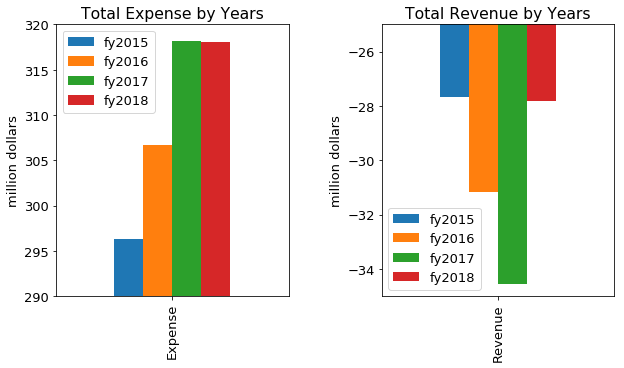

In [9]:
ax_list = list(plt.subplots(nrows=1, ncols=2, figsize=(10,5))[1])

pd_rev_and_exp[:1].plot.bar(ax=ax_list[0], title='Total Expense by Years', ylim=(290,320))
pd_rev_and_exp[1:].plot.bar(ax=ax_list[1], title='Total Revenue by Years', ylim=(-35,-25))

ax_list[0].set_xlabel('')
ax_list[0].set_ylabel('million dollars')
ax_list[1].set_xlabel('')
ax_list[1].set_ylabel('million dollars')
plt.subplots_adjust(wspace=0.4)
None

In [10]:
#I re-graph the total expense and revenue to make it observable. 
#Notice a increasing trend in both expense and revenue from 2015 to 2017, but the trend breaks in 2018.
#Therefore, I will try to figure out what causes the difference by comparing the data of 2017 and 2018.

In [11]:
pd_rev_678 = pd.read_sql('SELECT agency, SUM(fy2016) AS rev_16, SUM(fy2017) AS rev_17, SUM(fy2018) AS rev_18 '
                         'FROM expenditure_table '
                         'WHERE account_type ="Revenue" '
                         'GROUP BY agency', conn)
pd_rev_678 = pd_rev_678.set_index("agency")
pd_rev_678.head()

,rev_16,rev_17,rev_18
agency,,,
00 - UNDEFINED,0.000000,0.000000,0.000000
11 - ATTORNEY,-0.038957,-0.005684,-0.041626
12 - CIVIL RIGHTS,-0.121425,0.040150,-0.000450
13 - CLERK,-0.000219,-0.985080,0.000000
14 - COMMON COUNCIL,-0.019411,-0.019720,-0.015524


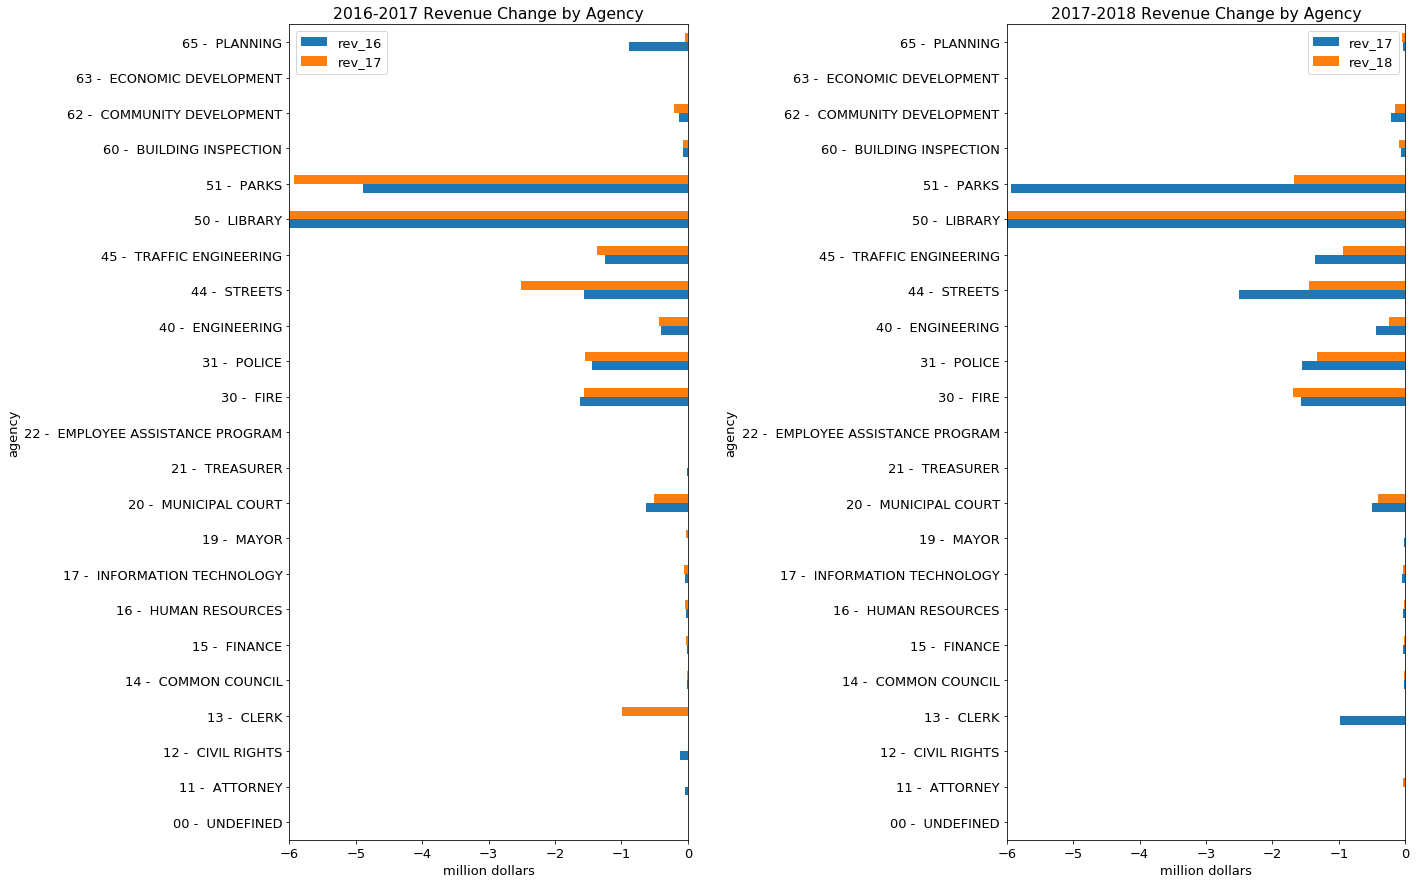

In [12]:
ax_list = list(plt.subplots(nrows=1, ncols=2, figsize=(20,15))[1])
pd_rev_678[['rev_16', 'rev_17']].plot.barh(ax=ax_list[0], xlim=(-6,0), title='2016-2017 Revenue Change by Agency')
pd_rev_678[['rev_17', 'rev_18']].plot.barh(ax=ax_list[1], xlim=(-6,0), title='2017-2018 Revenue Change by Agency')

ax_list[0].set_xlabel('million dollars')
ax_list[1].set_xlabel('million dollars')
plt.subplots_adjust(wspace=0.8)
None

In [13]:
#Out of the 6 million dollars decrease, 4 million come from Parks, 1 million each from Clerk and Streets.
#These are all significant changes compared to its volume.

In [14]:
pd_exp_678 = pd.read_sql('SELECT agency, SUM(fy2016) AS exp_16, SUM(fy2017) AS exp_17, SUM(fy2018) AS exp_18 '
                         'FROM expenditure_table '
                         'WHERE account_type ="Expense" '
                         'GROUP BY agency', conn)
pd_exp_678 = pd_exp_678.set_index("agency")
pd_exp_678.head()

,exp_16,exp_17,exp_18
agency,,,
00 - UNDEFINED,62.557729,67.219298,58.540306
10 - ASSESSOR,2.312123,2.491810,2.671716
11 - ATTORNEY,2.775633,2.989084,2.993189
12 - CIVIL RIGHTS,1.471954,1.482644,1.740774
13 - CLERK,2.394929,2.266173,2.223049


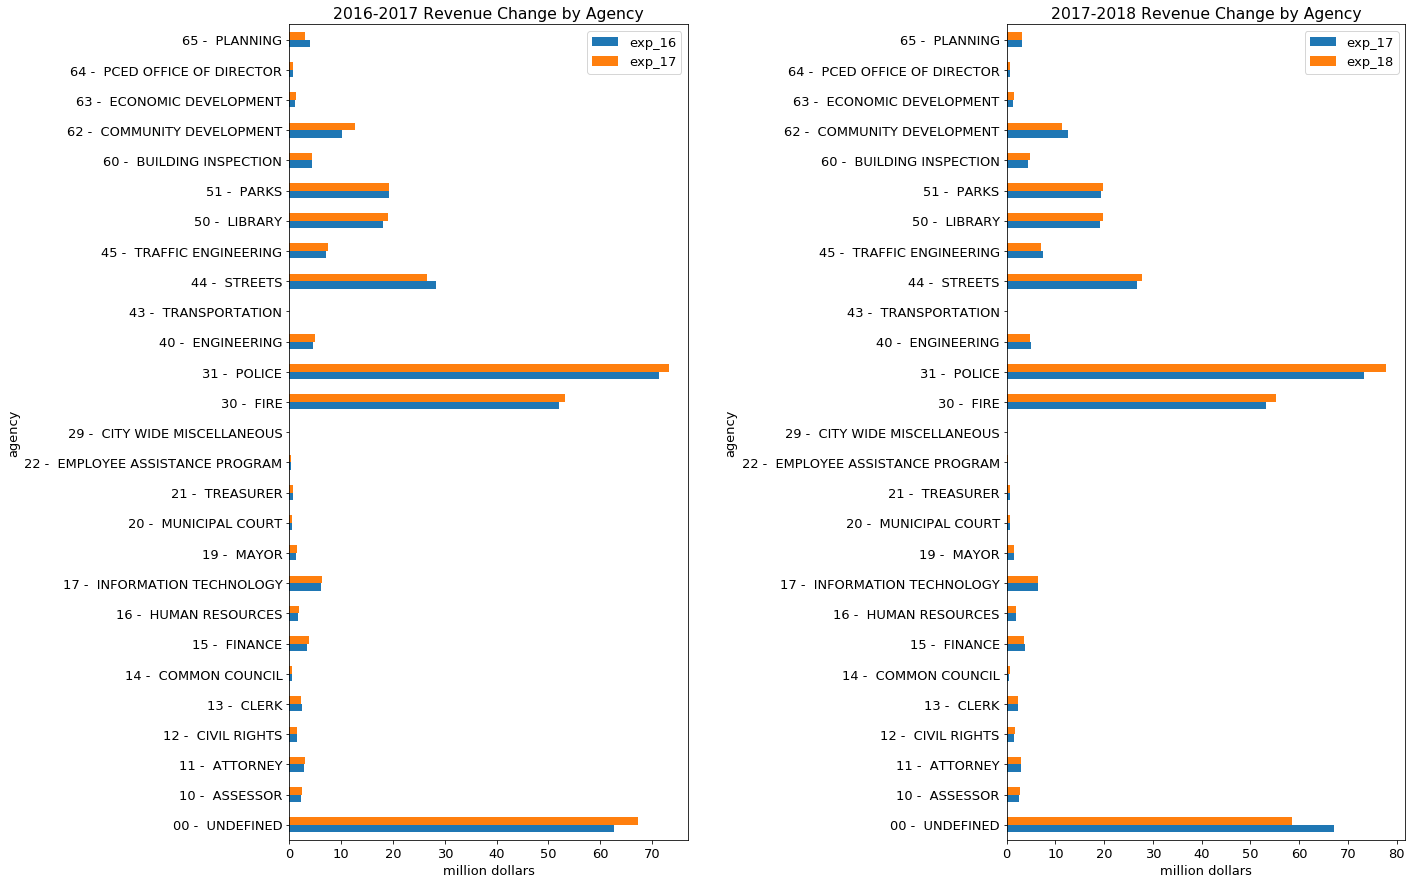

In [15]:
ax_list = list(plt.subplots(nrows=1, ncols=2, figsize=(20,15))[1])
pd_exp_678[['exp_16', 'exp_17']].plot.barh(ax=ax_list[0], title='2016-2017 Revenue Change by Agency')
pd_exp_678[['exp_17', 'exp_18']].plot.barh(ax=ax_list[1], title='2017-2018 Revenue Change by Agency')

ax_list[0].set_xlabel('million dollars')
ax_list[1].set_xlabel('million dollars')
plt.subplots_adjust(wspace=0.8)
None

In [16]:
pd_te_15 = pd.read_sql('SELECT organization, SUM(fy2015) as net_2015 '
                       'FROM expenditure_table '
                       'WHERE agency = "45 -  TRAFFIC ENGINEERING" '
                       'GROUP BY organization '
                       'HAVING net_2015>0.3 '
                       'ORDER BY net_2015 DESC', conn)
#pd_te_15

In [17]:
#sum(pd_te[19:]['net_2015']) #0.66

In [18]:
pd_te = pd.read_sql('SELECT organization, SUM(fy2015) as net_2015, SUM(fy2016) as net_2016, SUM(fy2017) as net_2017, SUM(fy2018) as net_2018 '
                    'FROM expenditure_table '
                    'WHERE agency = "45 -  TRAFFIC ENGINEERING" '
                    'GROUP BY organization '
                    'ORDER BY net_2015 DESC ', conn)
pd_te = pd_te.set_index('organization')
pd_te

,net_2015,net_2016,net_2017,net_2018
organization,,,,
45200 - TE STLIGHT,0.942028,0.963619,1.141899,1.171416
45405 - TE COMM MAINTENANCE,0.527896,0.299843,0.222784,0.141889
45105 - TE SIGNING MAINTENANCE,0.468542,0.431618,0.520065,0.404144
45101 - TE SIGNING ADMIN,0.455879,0.375836,0.367475,0.462494
45600 - TE SERVICES,0.444914,0.359414,0.554651,0.622603
45300 - TE PAVE MARK,0.354513,0.208990,0.235741,0.331503
45501 - TE SIGNALS ADMIN,0.351343,0.255291,0.329915,0.240971
45505 - TE SIGNALS MAINTENANCE,0.329984,0.434212,0.362112,0.325794
45667 - TE SERVICES GEOMETRICS,0.284114,0.143068,0.241349,0.288898


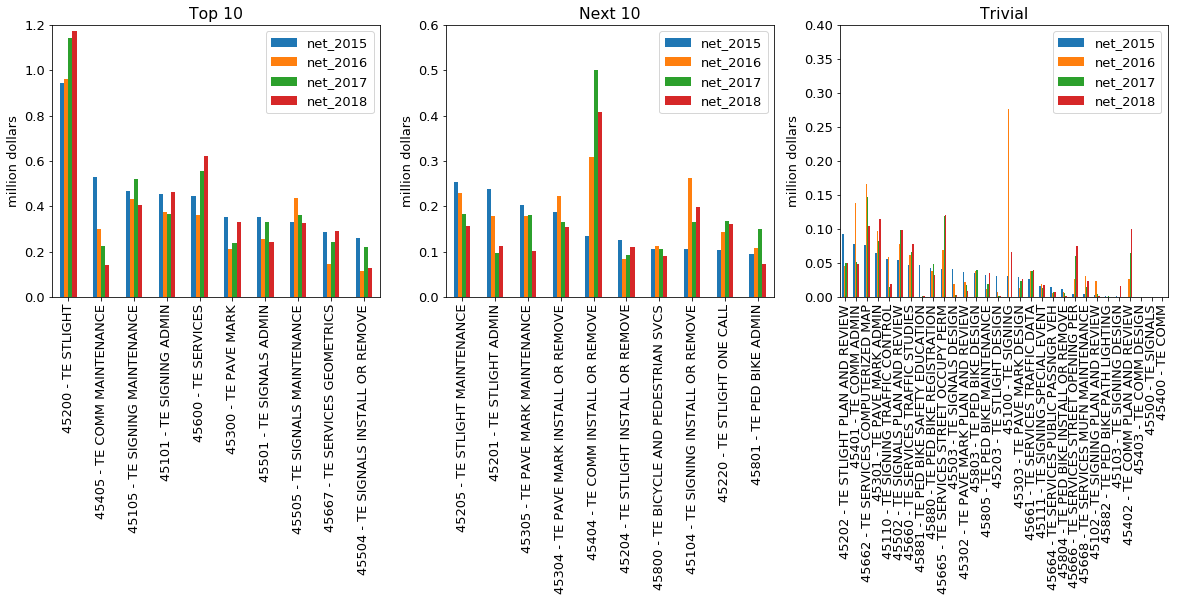

In [19]:
ax_list = list(plt.subplots(nrows=1, ncols=3, figsize=(20,5))[1])

pd_te[:10].plot.bar(ax=ax_list[0], ylim=(0,1.2), title="Top 10")
pd_te[10:20].plot.bar(ax=ax_list[1], ylim=(0,0.6), title="Next 10")
pd_te[20:].plot.bar(ax=ax_list[2], ylim=(0,0.4), title="Trivial")

ax_list[0].set_ylabel('million dollars')
ax_list[1].set_ylabel('million dollars')
ax_list[2].set_ylabel('million dollars')
ax_list[0].set_xlabel('')
ax_list[1].set_xlabel('')
ax_list[2].set_xlabel('')

None

In [20]:
#Communication Maintenance, why keep decreasing???
#Communication installation and removal, why increasing so fast???
#What happened to Signing in 2016???

In [21]:
pd_te_abn = pd.read_sql('SELECT organization, SUM(fy2015) as fy2015, SUM(fy2016) as fy2016, SUM(fy2017) as fy2017, SUM(fy2018) as fy2018 '
                    'FROM expenditure_table '
                    'WHERE agency = "45 -  TRAFFIC ENGINEERING" '
                    'GROUP BY organization '
                    'HAVING organization = "45405 - TE COMM MAINTENANCE" OR organization = "45404 - TE COMM INSTALL OR REMOVE" OR organization = "45100 - TE SIGNING" '
                    'ORDER BY fy2015 DESC ', conn)
pd_te_abn = pd_te_abn.set_index('organization').T
pd_te_abn

organization,45405 - TE COMM MAINTENANCE,45404 - TE COMM INSTALL OR REMOVE,45100 - TE SIGNING
fy2015,0.527896,0.133354,0.030104
fy2016,0.299843,0.308049,0.276087
fy2017,0.222784,0.499954,-0.122810
fy2018,0.141889,0.408942,0.066210


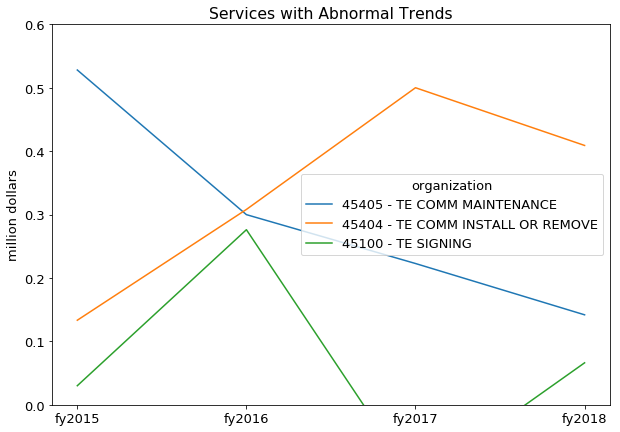

In [50]:
ax = pd_te_abn.plot.line(ylim=(0,0.6), title='Services with Abnormal Trends', figsize=(10,7))
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(pd_te_abn.index)
ax.set_ylabel('million dollars')
None

In [33]:
pd_te_rev = pd.read_sql('SELECT character_code, SUM(fy2015) as fy2015, SUM(fy2016) as fy2016, SUM(fy2017) as fy2017, SUM(fy2018) as fy2018 '
                    'FROM expenditure_table '
                    'WHERE agency = "45 -  TRAFFIC ENGINEERING" AND account_type = "Revenue" '
                    'GROUP BY character_code '
                    'ORDER BY fy2015 ASC ', conn)
pd_te_rev = pd_te_rev.set_index('character_code')
pd_te_rev

,fy2015,fy2016,fy2017,fy2018
character_code,,,,
47 - MISC REVENUE,-0.264653,-0.268551,-0.307608,-0.337211
42 - INTERGOV REVENUES,-0.207771,-0.719676,-0.715455,-0.316461
43 - CHARGES FOR SERVICES,-0.124977,-0.257434,-0.257104,-0.230674
49 - TRANSFER IN,-0.022015,-0.001153,-0.085973,-0.053310
48 - OTHER FINANCE SOURCE,0.000503,0.000000,0.000000,0.000000


In [35]:
pd_te_rev['fy2015'] *= (-1)
pd_te_rev['fy2016'] *= (-1)
pd_te_rev['fy2017'] *= (-1)
pd_te_rev['fy2018'] *= (-1)
pd_te_rev = pd_te_rev.drop('48 - OTHER FINANCE SOURCE')
pd_te_rev = pd_te_rev.T

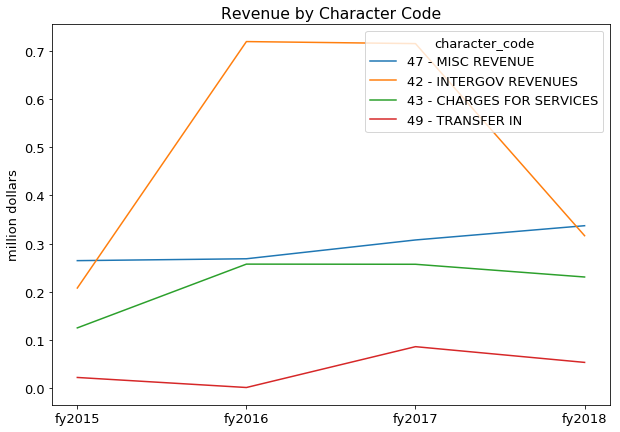

In [49]:
ax = pd_te_rev.plot.line(title='Revenue by Character Code', figsize=(10,7))
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(pd_te_rev.index)
ax.set_ylabel('million dollars')
None

In [41]:
pd_te_exp = pd.read_sql('SELECT character_code, SUM(fy2015) as net_2015, SUM(fy2016) as net_2016, SUM(fy2017) as net_2017, SUM(fy2018) as net_2018 '
                    'FROM expenditure_table '
                    'WHERE agency = "45 -  TRAFFIC ENGINEERING" AND account_type = "Expense" '
                    'GROUP BY character_code '
                    'ORDER BY net_2015 DESC ', conn)
pd_te_exp = pd_te_exp.set_index('character_code')
pd_te_exp

,net_2015,net_2016,net_2017,net_2018
character_code,,,,
51 - SALARIES,3.858105,3.700787,3.774441,3.857288
54 - PURCHASED SERVICES,1.750487,1.822807,1.868461,1.866264
52 - BENEFITS,1.367526,1.258440,1.564778,1.431864
53 - SUPPLIES,0.470932,0.318920,0.300423,0.251672
57 - INTER DEPART CHARGES,0.468694,0.481606,0.390484,0.281185
59 - TRANSFER OUT,0.000000,0.020337,0.027934,0.000000
58 - INTER DEPART BILLING,-0.762141,-0.546108,-0.529250,-0.594969


In [42]:
pd_te_exp = pd_te_exp.drop('58 - INTER DEPART BILLING')
pd_te_exp = pd_te_exp.T
pd_te_exp

character_code,51 - SALARIES,54 - PURCHASED SERVICES,52 - BENEFITS,53 - SUPPLIES,57 - INTER DEPART CHARGES,59 - TRANSFER OUT
net_2015,3.858105,1.750487,1.367526,0.470932,0.468694,0.000000
net_2016,3.700787,1.822807,1.258440,0.318920,0.481606,0.020337
net_2017,3.774441,1.868461,1.564778,0.300423,0.390484,0.027934
net_2018,3.857288,1.866264,1.431864,0.251672,0.281185,0.000000


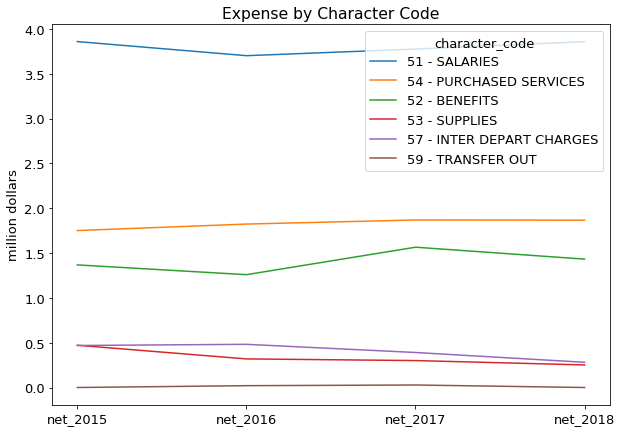

In [48]:
ax = pd_te_exp.plot.line(title='Expense by Character Code', figsize=(10,7))
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(pd_te_exp.index)
ax.set_ylabel('million dollars')
None